# FuseTS - MOGPR

This Jupyter Notebook implements the MOGPR service, which is part of the FuseTS toolbox. The purpose of this notebook is to showcase the utilization of openEO to execute the MOGPR service for a specific area of interest (AOI).

The MOGPR service is designed to enable multi-output regression analysis using Gaussian Process Regression (GPR) on geospatial data. It provides a powerful tool for understanding and predicting spatio-temporal phenomena by filling gaps based on other indicators that are correlated with each other.

Within this notebook, you will find the necessary code and instructions to retrieve relevant geospatial data for your AOI using openEO. The openEO framework facilitates seamless integration and processing of geospatial data, making it an ideal environment for executing the MOGPR service.


## Setting up the OpenEO process
The first step includes setting up the OpenEO processing through the [OpenEO Python Client](https://open-eo.github.io/openeo-python-client/). Since the MOGPR algorithm is integrated as an [user defined process](https://open-eo.github.io/openeo-python-client/cookbook/udp_sharing.html), we can use the `datacube_from_process` function to execute the service.

In [21]:
import json

import matplotlib.pyplot as plt
import openeo
import pandas as pd
from openeo.rest.conversions import timeseries_json_to_pandas

In [22]:
connection = openeo.connect("openeo.vito.be").authenticate_oidc()
service = 'mogpr'
namespace = 'u:fusets'

Authenticated using refresh token.


In [23]:
connection.describe_process(service, namespace=namespace)

{'description': '# Multi output gaussian process regression\n\n## Description\n\nCompute an integrated timeseries based on multiple inputs.\nFor instance, combine Sentinel-2 NDVI with Sentinel-1 RVI into one integrated NDVI.\n\n## Usage\n\nUsage examples for the MOGPR process.\n\n### Python\n\nThis code example highlights the usage of the MOGPR process in an OpenEO batch job.\nThe result of this batch job will consist of individual GeoTIFF files per date.\nGenerating multiple GeoTIFF files as output is only possible in a batch job.\n\n```python\nimport openeo\n\n# define ROI and TOI\nextent = {\n    "west": 640860,\n    "south": 5676170,\n    "east": 643420,\n    "north": 5678730,\n    "crs": "EPSG:32631"\n}\n\nstartdate = "2020-05-01"\nenddate = "2020-06-01"\n\n# get datacube\nconnection = openeo.connect("https://openeo.cloud")\ncube = connection.datacube_from_process(\n    "MOGPR",\n    namespace="u:fusets",\n)\njob = cube.execute_batch(out_format="GTIFF")\nresults = job.get_results()\nresults.download_files("out")  # write files to output directory\n```\n\nFor small spatial and temporal extents, it is possible to get the results directly in a synchronous call:\n\n```python\ncube = connection.datacube_from_process(\n    "MOGPR",\n    namespace="u:fusets",\n)\ncube.download("output.nc", format="NetCDF")\n```\n\n## Limitations\n\nThe spatial extent is limited to a maximum size equal to a Sentinel-2 MGRS tile (100 km x 100 km).\n\n## Configuration & Resource Usage\n\nRun configurations for different ROI/TOI with memory requirements and estimated run durations.\n\n### Synchronous calls\n\nTODO: Replace with actual measurements!!!\n\n| Spatial extent | Run duration |\n|----------------|--------------|\n| 100 m x 100 m  | 1 minute     |\n| 500m x 500 m   | 1 minute     |\n| 1 km x 1 km    | 1 minute     |\n| 5 km x 5 km    | 2 minutes    |\n| 10 km x 10 km  | 3 minutes    |\n| 50 km x 50 km  | 9 minutes    |\n\nThe maximum duration of a synchronous run is 15 minutes.\nFor long running computations, you can use batch jobs.\n\n### Batch jobs\n\nTODO: Replace with actual measurements!!!\n\n| Spatial extent  | Temporal extent | Executor memory | Run duration |\n|-----------------|-----------------|-----------------|--------------|\n| 100 m x 100 m   | 1 month         | default         | 7 minutes    |\n| 500 m x 100 m   | 1 month         | default         | 7 minutes    |\n| 1 km x 1 km     | 1 month         | default         | 7 minutes    |\n| 5 km x 5 km     | 1 month         | default         | 10 minutes   |\n| 10 km x 10 km   | 1 month         | default         | 11 minutes   |\n| 50 km x 50 km   | 1 month         | 6 GB            | 20 minutes   |\n| 100 km x 100 km | 1 month         | 7 GB            | 34 minutes   |\n| 100m x 100 m    | 7 months        | default         | 10 minutes   |\n| 500 m x 500 m   | 7 months        | default         | 10 minutes   |\n| 1 km x 1 km     | 7 months        | default         | 14 minutes   |\n| 5 km x 5 km     | 7 months        | default         | 14 minutes   |\n| 10 km x 10 km   | 7 months        | default         | 19 minutes   |\n| 50 km x 50 km   | 7 months        | 6 GB            | 45 minutes   |\n| 100 km x 100 km | 7 months        | 8 GB            | 65 minutes   |\n\nThe executor memory defaults to 5 GB. You can increase the executor memory by specifying it as a job option, eg:\n\n```python\njob = cube.execute_batch(out_format="GTIFF", job_options={"executor-memory": "7g"})\n```',
 'id': 'mogpr',
 'parameters': [{'description': 'A data cube.',
   'name': 'data',
   'schema': {'subtype': 'raster-cube', 'type': 'object'}}],
 'summary': 'Integrates timeseries in data cube using multi-output gaussian process regression.'}

### Use `datacube_from_process` to get initial DataCube
Get output datacube from process by passing in the process parameters:
**Mandatory**
- `data`: The initial datacube upon which to execute the service


In [24]:
spat_ext = {
    "type": "Polygon",
    "coordinates": [
        [
            [
                5.170012098271149,
                51.25062964728295
            ],
            [
                5.17085904378298,
                51.24882567194015
            ],
            [
                5.17857421368097,
                51.2468515482926
            ],
            [
                5.178972704726344,
                51.24982704376254
            ],
            [
                5.170012098271149,
                51.25062964728295
            ]
        ]
    ]
}
temp_ext = ["2022-05-01", "2023-07-31"]


In [25]:
scl = connection.load_collection('SENTINEL2_L2A_SENTINELHUB',
                                  spatial_extent=spat_ext,
                                  temporal_extent=temp_ext,
                                  bands=["SCL"])
cloud_mask = scl.process(
    "to_scl_dilation_mask",
    data=scl,
    kernel1_size=17, kernel2_size=77,
    mask1_values=[2, 4, 5, 6, 7],
    mask2_values=[3, 8, 9, 10, 11],
    erosion_kernel_size=3)
base = connection.load_collection('SENTINEL2_L2A_SENTINELHUB',
                                  spatial_extent=spat_ext,
                                  temporal_extent=temp_ext,
                                  bands=["B04", "B08"])
base_cloudmasked = base.mask(cloud_mask)
base_ndvi = base_cloudmasked.ndvi(red="B04", nir="B08")

In [26]:
mogpr = connection.datacube_from_process(service,
                                         namespace=f'https://openeo.vito.be/openeo/1.1/processes/{namespace}/{service}',
                                         data=base_ndvi)
mogpr = mogpr.aggregate_spatial(spat_ext, reducer='mean')

/home/bramjanssen/.local/lib/python3.6/site-packages/openeo/metadata.py:255: UserWarning: No cube:dimensions metadata
  complain("No cube:dimensions metadata")


### Execute job and download result

In [27]:
mogpr_job = mogpr.execute_batch('./mogpr.json', out_format="json", title=f'FuseTS - MOGPR', job_options={
    'udf-dependency-archives': [
        'https://artifactory.vgt.vito.be:443/artifactory/auxdata-public/ai4food/fusets_venv.zip#tmp/venv',
        'https://artifactory.vgt.vito.be:443/artifactory/auxdata-public/ai4food/fusets.zip#tmp/venv_static'
    ],
    'executor-memory': '7g'
})

0:00:00 Job 'j-e8002603adfc4ee3b1397d674f821b64': send 'start'
0:00:24 Job 'j-e8002603adfc4ee3b1397d674f821b64': queued (progress N/A)
0:00:29 Job 'j-e8002603adfc4ee3b1397d674f821b64': queued (progress N/A)
0:00:36 Job 'j-e8002603adfc4ee3b1397d674f821b64': queued (progress N/A)
0:00:44 Job 'j-e8002603adfc4ee3b1397d674f821b64': queued (progress N/A)
0:01:04 Job 'j-e8002603adfc4ee3b1397d674f821b64': queued (progress N/A)
0:01:33 Job 'j-e8002603adfc4ee3b1397d674f821b64': queued (progress N/A)
0:01:48 Job 'j-e8002603adfc4ee3b1397d674f821b64': running (progress N/A)
0:02:07 Job 'j-e8002603adfc4ee3b1397d674f821b64': running (progress N/A)
0:02:31 Job 'j-e8002603adfc4ee3b1397d674f821b64': running (progress N/A)
0:03:01 Job 'j-e8002603adfc4ee3b1397d674f821b64': running (progress N/A)
0:03:39 Job 'j-e8002603adfc4ee3b1397d674f821b64': running (progress N/A)
0:04:25 Job 'j-e8002603adfc4ee3b1397d674f821b64': running (progress N/A)
0:05:24 Job 'j-e8002603adfc4ee3b1397d674f821b64': running (progress

In [28]:
base_ndvi = base_ndvi.aggregate_spatial(spat_ext, reducer='mean')
base_ndvi.download('./base.json', format='json')

## Explore the results
Having obtained both the base NDVI and the MOGPR version, we can now proceed to compare the outcomes.

In [29]:
cubes_dfs = []
cols = ['Raw NDVI', 'MOGPR NDVI']
for result in ['base.json', 'mogpr.json']:
    with open(result, 'r') as result_file:
        df = timeseries_json_to_pandas(json.load(result_file))
        df.index = pd.to_datetime(df.index)
        cubes_dfs.append(df)
        result_file.close()
joined_df = pd.concat(cubes_dfs, axis=1)
joined_df = joined_df.rename(columns={0: cols[0], 1: cols[1]})

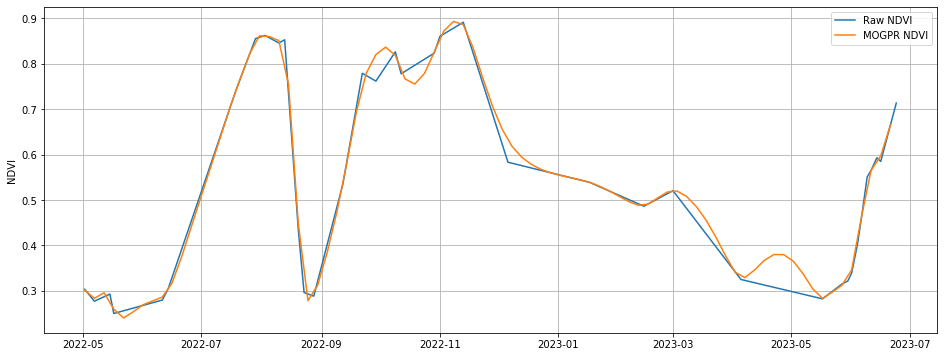

In [30]:
plt.figure(figsize=(16, 6))
for col in cols:
    values = joined_df[~joined_df[col].isna()]
    plt.plot(values.index, values[col], '-', label=col)
plt.ylabel('NDVI')
plt.grid(True)
plt.legend()